## K-means clustering - San Fransisco

This notebook use K-means clustering to cluster different users 

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import scipy.stats
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


### Load Data

In [6]:
cities_years = {
    'London': [2018, 2019, 2020],
    'Los_Angeles': [2018, 2019, 2020],
    'San_Francisco': [2018, 2019, 2020],
}

import seaborn as sns
cities_colors = {
    'London': sns.color_palette("Blues", n_colors = 3),
    'Los_Angeles': sns.color_palette("Reds", n_colors = 3),
    'San_Francisco': sns.color_palette("Greens", n_colors = 3),
}

In [8]:
from collections import defaultdict
dfs = defaultdict(dict)
dfall = []

for city, years in cities_years.items():
    for year in years:
        print("Loading: ", city, year)
        df = pd.read_csv("../data/raw/observations_v2/CNC_{}_{}.csv".format(city, year))
        dfs[city][year] = df
        dfall.append(df)

dfall = pd.concat(dfall)
dfs['San_Francisco'][2018].head()

Loading:  London 2018
Loading:  London 2019
Loading:  London 2020
Loading:  Los_Angeles 2018
Loading:  Los_Angeles 2019
Loading:  Los_Angeles 2020
Loading:  San_Francisco 2018
Loading:  San_Francisco 2019
Loading:  San_Francisco 2020


,id,observed_on_string,time_observed_at,created_time_zone,created_at,updated_at,description,user_id,user_login,quality_grade,...,preferred_common_name,iconic_taxon_name,taxon_rank,taxon_parent_id,taxon_native,taxon_endemic,taxon_threatened,taxon_search_rank,taxon_observations,identifications
0,11421522,Mon Apr 30 2018 16:05:01 GMT-0700 (PDT),2018-04-30T16:05:01-07:00,America/Los_Angeles,2018-04-25T09:01:33-07:00,2018-04-30T16:05:54-07:00,Hmmm. I think it’s correct but I’m not 💯% sure.,898721,parallelbear,casual,...,southern magnolia,Plantae,species,82096,False,False,False,14018,14018,"[{'user_id': 898721, 'category': 'leading', 'd..."
1,11478879,Fri Apr 27 2018 00:01:10 GMT-0700 (PDT),2018-04-27T00:01:10-07:00,America/Los_Angeles,2018-04-27T00:01:40-07:00,2018-04-27T00:01:47-07:00,Hmmm. I think it’s correct but I’m not 💯% sure.,28,tiwane,needs_id,...,Non-biting Midges,Insecta,family,509764,False,False,False,30182,30182,"[{'user_id': 28, 'category': 'leading', 'disag..."
2,11478904,Fri Apr 27 2018 00:02:28 GMT-0700 (PDT),2018-04-27T00:02:28-07:00,America/Los_Angeles,2018-04-27T00:02:40-07:00,2019-04-24T07:31:07-07:00,Hmmm. I think it’s correct but I’m not 💯% sure.,28,tiwane,research,...,Bathroom Moth Fly,Insecta,species,247953,False,False,False,5215,5215,"[{'user_id': 28, 'category': 'improving', 'dis..."
3,11478940,Fri Apr 27 2018 00:03:19 GMT-0700 (PDT),2018-04-27T00:03:19-07:00,America/Los_Angeles,2018-04-27T00:03:37-07:00,2018-04-27T19:45:17-07:00,Hmmm. I think it’s correct but I’m not 💯% sure.,28,tiwane,research,...,Annual Meadow-grass,Plantae,species,52809,False,False,False,6778,6778,"[{'user_id': 13377, 'category': 'supporting', ..."
4,11478955,Fri Apr 27 2018 00:03:47 GMT-0700 (PDT),2018-04-27T00:03:47-07:00,America/Los_Angeles,2018-04-27T00:04:11-07:00,2018-04-27T00:49:44-07:00,Hmmm. I think it’s correct but I’m not 💯% sure.,28,tiwane,research,...,common groundsel,Plantae,species,53207,False,False,False,12328,12328,"[{'user_id': 179103, 'category': 'improving', ..."


In [9]:
sf_2018 = dfs['San_Francisco'][2018]
sf_2018

,id,observed_on_string,time_observed_at,created_time_zone,created_at,updated_at,description,user_id,user_login,quality_grade,...,preferred_common_name,iconic_taxon_name,taxon_rank,taxon_parent_id,taxon_native,taxon_endemic,taxon_threatened,taxon_search_rank,taxon_observations,identifications
0,11421522,Mon Apr 30 2018 16:05:01 GMT-0700 (PDT),2018-04-30T16:05:01-07:00,America/Los_Angeles,2018-04-25T09:01:33-07:00,2018-04-30T16:05:54-07:00,Hmmm. I think it’s correct but I’m not 💯% sure.,898721,parallelbear,casual,...,southern magnolia,Plantae,species,82096,False,False,False,14018,14018,"[{'user_id': 898721, 'category': 'leading', 'd..."
1,11478879,Fri Apr 27 2018 00:01:10 GMT-0700 (PDT),2018-04-27T00:01:10-07:00,America/Los_Angeles,2018-04-27T00:01:40-07:00,2018-04-27T00:01:47-07:00,Hmmm. I think it’s correct but I’m not 💯% sure.,28,tiwane,needs_id,...,Non-biting Midges,Insecta,family,509764,False,False,False,30182,30182,"[{'user_id': 28, 'category': 'leading', 'disag..."
2,11478904,Fri Apr 27 2018 00:02:28 GMT-0700 (PDT),2018-04-27T00:02:28-07:00,America/Los_Angeles,2018-04-27T00:02:40-07:00,2019-04-24T07:31:07-07:00,Hmmm. I think it’s correct but I’m not 💯% sure.,28,tiwane,research,...,Bathroom Moth Fly,Insecta,species,247953,False,False,False,5215,5215,"[{'user_id': 28, 'category': 'improving', 'dis..."
3,11478940,Fri Apr 27 2018 00:03:19 GMT-0700 (PDT),2018-04-27T00:03:19-07:00,America/Los_Angeles,2018-04-27T00:03:37-07:00,2018-04-27T19:45:17-07:00,Hmmm. I think it’s correct but I’m not 💯% sure.,28,tiwane,research,...,Annual Meadow-grass,Plantae,species,52809,False,False,False,6778,6778,"[{'user_id': 13377, 'category': 'supporting', ..."
4,11478955,Fri Apr 27 2018 00:03:47 GMT-0700 (PDT),2018-04-27T00:03:47-07:00,America/Los_Angeles,2018-04-27T00:04:11-07:00,2018-04-27T00:49:44-07:00,Hmmm. I think it’s correct but I’m not 💯% sure.,28,tiwane,research,...,common groundsel,Plantae,species,53207,False,False,False,12328,12328,"[{'user_id': 179103, 'category': 'improving', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,59024459,2018/04/29 11:26 AM PDT,2018-04-29T11:26:00-07:00,America/Los_Angeles,2020-09-09T00:20:53-07:00,2020-09-09T00:22:33-07:00,NaN,2111627,arlenedevitt,needs_id,...,Hedgenettles,Plantae,genus,918913,False,False,False,35922,35922,"[{'user_id': 2111627, 'category': 'leading', '..."
43088,61257901,2018-04-29 2:22:03 PM PDT,2018-04-29T14:22:03-07:00,America/Los_Angeles,2020-09-29T16:17:52-07:00,2020-09-29T16:18:10-07:00,NaN,3081209,matthewfrantz1,casual,...,Dally pine,Plantae,species,60561,False,False,False,666,666,"[{'user_id': 3081209, 'category': 'leading', '..."
43089,61274273,Sun Apr 29 2018 10:39:48 GMT-0700 (PDT),2018-04-29T10:39:48-07:00,America/Los_Angeles,2020-09-29T20:52:48-07:00,2020-09-29T20:52:57-07:00,NaN,3530629,katiepeng,needs_id,...,Dally pine,Plantae,genus,900986,False,False,False,1265,1265,"[{'user_id': 3530629, 'category': 'leading', '..."
43090,61274563,Sun Apr 29 2018 10:39:56 GMT-0700 (PDT),2018-04-29T10:39:56-07:00,America/Los_Angeles,2020-09-29T20:58:43-07:00,2020-09-29T20:58:50-07:00,NaN,3530629,katiepeng,casual,...,Fortnight Lilies,Plantae,genus,790633,False,False,False,8591,8591,"[{'user_id': 3530629, 'category': 'leading', '..."


# Calculate participation

## Get number of observations and identifications

In [10]:
def get_obs_idents_per_user(dfcity):
    """ Calculate the number of observations and identifications per user 
    
    Input:
    ------
     - dfcity: pd.DataFrame
         The observations data for one city.
    
    Returns:
    -------
     - dfobsident: pd.DataFrame
         Has the columns: user_id | n_obs | n_idents
    
    """
    from collections import defaultdict
    n_obs = defaultdict(int)
    n_idents = defaultdict(int)


    for _, row in dfcity.iterrows():
        # Count observation to user that observed
        user_obs = row['user_id']
        n_obs[user_obs] += 1

        # Count identications the user did
        identifications = eval(row['identifications'])
        for ident in identifications:
            user_ident = ident['user_id']
            if user_ident != user_obs:
                n_idents[user_ident] += 1
    # Create dataframe with observations, identifications
    dfobsident = pd.DataFrame([n_obs, n_idents]).T.reset_index().convert_dtypes().fillna(0)
    dfobsident.columns = ['user_id', 'n_obs', 'n_idents']
    dfobsident
    return dfobsident

## San Francisco 2018

In [11]:
dfcity = dfs['San_Francisco'][2018]
sf_2018 = get_obs_idents_per_user(dfcity)
sf_2018.sort_values('user_id')

,user_id,n_obs,n_idents
286,1,167,1553
1279,5,7,0
817,17,29,0
1,28,305,704
2160,36,0,1
...,...,...,...
1752,3530629,2,0
2653,3553070,0,1
2336,3638742,0,3
2228,3765410,0,3


In [12]:
#test user 160
u_2018 = sf_2018.loc[sf_2018['user_id']==17]
u_2018

,user_id,n_obs,n_idents
817,17,29,0


In [13]:
print(sf_2018.shape)
print(sf_2018.dtypes)

(2931, 3)
user_id     Int64
n_obs       Int64
n_idents    Int64
dtype: object


In [14]:
sf_2018.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,2931.0,704881.809280,555246.647347,1.0,291812.5,751558.0,917173.5,3793877.0
n_obs,2931.0,14.702149,53.942008,0.0,0.0,1.0,6.0,889.0
n_idents,2931.0,18.219379,153.572348,0.0,0.0,1.0,3.0,5568.0


In [15]:
#log transform
#step before log transformation to avoid the zeros 
sf_2018['obs_count_1']=sf_2018['n_obs']+1
sf_2018['ident_count_1']=sf_2018['n_idents']+1

In [16]:
#log transform
sf_2018['obs_count_log'] = np.log(sf_2018['obs_count_1'])
sf_2018['ident_count_log'] = np.log(sf_2018['ident_count_1'])

In [17]:
sf_2018.sort_values('user_id').head()

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
286,1,167,1553,168,1554,5.123964,7.348588
1279,5,7,0,8,1,2.079442,0.0
817,17,29,0,30,1,3.401197,0.0
1,28,305,704,306,705,5.723585,6.558198
2160,36,0,1,1,2,0.0,0.693147


In [18]:
#select varibles for plotting
df_select = sf_2018[['user_id','obs_count_log', 'ident_count_log']]
#create a copy of your dataframe:
df_std = df_select.copy()

In [19]:
#Don't include the user_id column in the transformation:
col_names = ['obs_count_log', 'ident_count_log']
features = df_std[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)



In [20]:
df_std.sort_values('user_id').head()

,user_id,obs_count_log,ident_count_log
286,1,5.123964,7.348588
1279,5,2.079442,0.0
817,17,3.401197,0.0
1,28,5.723585,6.558198
2160,36,0.0,0.693147


In [21]:
#assign the result to those two columns
df_std[col_names] = features
df_std.rename(columns={'obs_count_log': 'obs_count_2018', 'ident_count_log': 'ident_count_2018'}, inplace=True)
df_std.sort_values('user_id')
#print(df_std)

,user_id,obs_count_2018,ident_count_2018
286,1,2.726010,4.758159
1279,5,0.614540,-0.699644
817,17,1.531218,-0.699644
1,28,3.141866,4.171136
2160,36,-0.827617,-0.184843
...,...,...,...
1752,3530629,-0.065695,-0.699644
2653,3553070,-0.827617,-0.184843
2336,3638742,-0.827617,0.329958
2228,3765410,-0.827617,0.329958


In [22]:
#define cololor 
color_dict = {'high activity':'red',
              'identifiers':'blue',
              'observers':'green',
              'low activity':'orange'}

In [23]:
label_dict = {0:'identifiers', 1:'low activity', 2:'high activity',3:'observers'}

kmeans = KMeans(n_clusters=4, random_state=42, max_iter=10).fit(df_std[['obs_count_2018',
                                                                        'ident_count_2018']])
df_std['cluster_2018'] = kmeans.labels_
df_std['user type 2018'] = [label_dict.get(i) for i in df_std.cluster_2018]
df_std.sort_values('user type 2018')

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user type 2018
210,16743,1.575978,1.826428,2,high activity
158,31080,1.575978,3.501067,2,high activity
994,282384,2.023401,1.629090,2,high activity
311,172345,1.988426,2.886349,2,high activity
153,794812,1.657664,1.691018,2,high activity
...,...,...,...,...,...
827,920455,0.415024,-0.699644,3,observers
826,920640,1.095259,-0.699644,3,observers
825,911896,2.147949,-0.699644,3,observers
845,89029,1.137304,-0.699644,3,observers


In [24]:
higha_2018 = df_std.loc[df_std['user type 2018']=='high activity']
higha_2018

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user type 2018
1,28,3.141866,4.171136,2,high activity
2,819,3.435052,3.339223,2,high activity
3,2692,3.206729,3.674031,2,high activity
4,28037,2.594593,4.021043,2,high activity
7,2991,3.882304,4.300375,2,high activity
...,...,...,...,...,...
1238,60643,2.713514,3.208961,2,high activity
1419,364405,1.747860,2.076327,2,high activity
1445,20125,1.951592,1.487194,2,high activity
1505,13370,1.507707,2.486884,2,high activity


In [25]:
lowa_2018 = df_std.loc[df_std['user type 2018']=='low activity']
lowa_2018

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user type 2018
5,907833,-0.346898,-0.699644,1,low activity
9,353235,-0.346898,-0.699644,1,low activity
11,162368,-0.065695,-0.699644,1,low activity
12,834951,-0.065695,-0.699644,1,low activity
13,876020,-0.065695,-0.699644,1,low activity
...,...,...,...,...,...
2926,1743320,-0.827617,-0.184843,1,low activity
2927,2248610,-0.827617,-0.184843,1,low activity
2928,1065672,-0.827617,-0.184843,1,low activity
2929,2806832,-0.827617,-0.184843,1,low activity


In [26]:
ob_2018 = df_std.loc[df_std['user type 2018']=='observers']
ob_2018

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user type 2018
0,898721,0.696226,0.116296,3,observers
6,35597,2.323298,-0.699644,3,observers
8,29323,2.931691,0.631097,3,observers
10,4259,1.730735,-0.184843,3,observers
15,907355,1.827664,-0.184843,3,observers
...,...,...,...,...,...
1725,2449494,0.521932,-0.699644,3,observers
1734,964887,1.095259,-0.699644,3,observers
1738,85904,0.614540,-0.699644,3,observers
1743,391500,0.415024,-0.699644,3,observers


In [27]:
id_2018 = df_std.loc[df_std['user type 2018']=='identifiers']
id_2018

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user type 2018
39,718846,0.835398,1.874361,0,identifiers
102,714,0.415024,1.359560,0,identifiers
143,27212,0.288578,2.076327,0,identifiers
238,748705,-0.346898,0.745585,0,identifiers
296,66538,-0.346898,1.205346,0,identifiers
...,...,...,...,...,...
2819,21855,-0.827617,0.631097,0,identifiers
2836,451364,-0.827617,2.389162,0,identifiers
2868,967882,-0.827617,0.844759,0,identifiers
2881,1077222,-0.827617,1.205346,0,identifiers


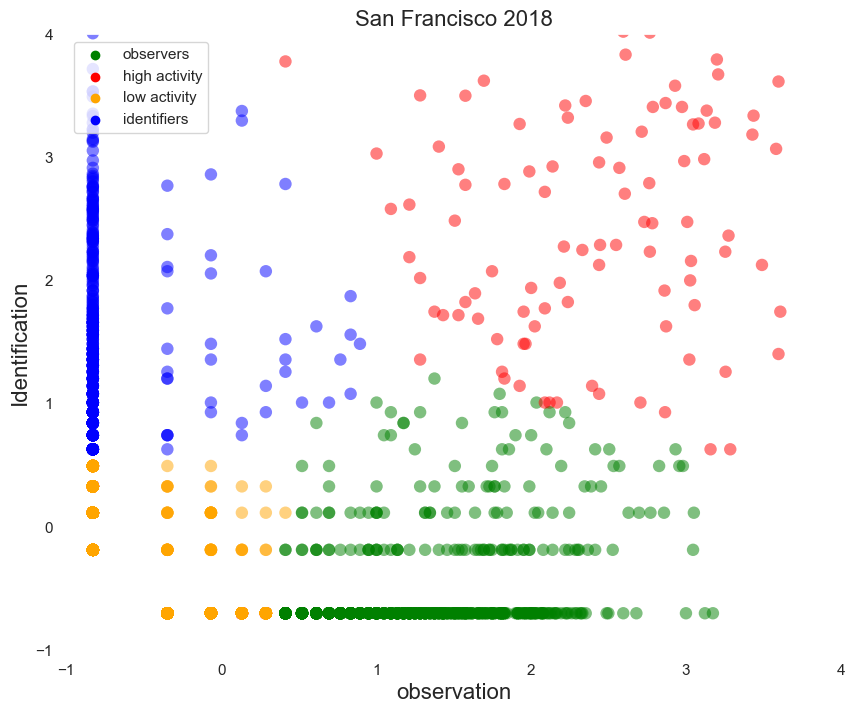

In [28]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(10,8))
ax = plt.axes()
sns.set(style="ticks")
ax = sns.scatterplot(data=df_std, x = 'obs_count_2018', y ='ident_count_2018',
                     hue='user type 2018',
                     palette=color_dict,
                     s=80, linewidth=0,alpha=0.5)
#ax.set(yscale="log")
#ax.set(xscale="log")
sns.set_style("ticks")
plt.legend(loc='upper left')
plt.title('San Francisco 2018',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(18,9))
for i in range(df_select.shape[0]):
 plt.text(x=df_std.obs_count[i]+0.3,y=df_std.ident_count[i]+0.3,s=df_select.user_id[i], 
          fontdict=dict(color='blue',size=10),
          bbox=dict(facecolor='yellow',alpha=0.5))
ax = sns.scatterplot(data=df_std, x = 'obs_count', y ='ident_count',
                     hue='user_type2018',
                     #palette=color_dict,
                     s=20, linewidth=0)
plt.legend(loc='upper left')
plt.title('London 2018')
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
plt.savefig('scatter.png')
plt.show()

## San Francisco 2019

In [29]:
dfcity = dfs['San_Francisco'][2019]
sf_2019 = get_obs_idents_per_user(dfcity)
sf_2019

,user_id,n_obs,n_idents
0,469701,1,0
1,402292,11,3
2,3494,558,140
3,34038,699,501
4,1,166,449
...,...,...,...
3298,3043610,0,1
3299,2844717,0,1
3300,3373525,0,1
3301,2866445,0,1


In [30]:
#step before log transformation to avoid the zeros 
sf_2019['obs_count_1']=sf_2019['n_obs']+1
sf_2019['ident_count_1']=sf_2019['n_idents']+1

In [31]:
#log transform
sf_2019['obs_count_log'] = np.log(sf_2019['obs_count_1'])
sf_2019['ident_count_log'] = np.log(sf_2019['ident_count_1'])

In [32]:
sf_2019.sort_values('user_id')

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
4,1,166,449,167,450,5.117994,6.109248
2778,17,0,4,1,5,0.0,1.609438
2307,28,0,381,1,382,0.0,5.945421
2681,160,0,4,1,5,0.0,1.609438
3069,172,0,3,1,4,0.0,1.386294
...,...,...,...,...,...,...,...
2658,3596875,0,1,1,2,0.0,0.693147
2144,3621768,1,0,2,1,0.693147,0.0
2235,3657355,0,1,1,2,0.0,0.693147
2147,3704356,1,0,2,1,0.693147,0.0


In [33]:
sf_2019.sort_values('user_id').head()

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
4,1,166,449,167,450,5.117994,6.109248
2778,17,0,4,1,5,0.0,1.609438
2307,28,0,381,1,382,0.0,5.945421
2681,160,0,4,1,5,0.0,1.609438
3069,172,0,3,1,4,0.0,1.386294


In [34]:
#frames = [lon_2018, lon_2019]
#sf_2019 = pd.concat(frames)
#sf_2019.sort_values('user_id')

In [35]:
#select varibles for plotting
df_select_2019 = sf_2019[['user_id','obs_count_log', 'ident_count_log']]

#create a copy of your dataframe:
df_std_2019 = df_select_2019.copy()
df_std_2019.sort_values('user_id')

,user_id,obs_count_log,ident_count_log
4,1,5.117994,6.109248
2778,17,0.0,1.609438
2307,28,0.0,5.945421
2681,160,0.0,1.609438
3069,172,0.0,1.386294
...,...,...,...
2658,3596875,0.0,0.693147
2144,3621768,0.693147,0.0
2235,3657355,0.0,0.693147
2147,3704356,0.693147,0.0


In [36]:
col_names = ['obs_count_log', 'ident_count_log']
features = df_std_2019[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [37]:
#assign the result to those two columns
df_std_2019[col_names] = features
df_std_2019.rename(columns={'obs_count_log': 'obs_count_2019', 'ident_count_log': 'ident_count_2019'}, inplace=True)
df_std_2019

,user_id,obs_count_2019,ident_count_2019
0,469701,-0.395394,-0.640347
1,402292,0.921843,0.451250
2,3494,3.745787,3.256410
3,34038,3.911148,4.256309
4,1,2.857594,4.170202
...,...,...,...
3298,3043610,-0.904971,-0.094548
3299,2844717,-0.904971,-0.094548
3300,3373525,-0.904971,-0.094548
3301,2866445,-0.904971,-0.094548


In [38]:
label_dict = {0:'observers', 1:'low activity', 2:'identifiers',3:'high activity'}

kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000).fit(df_std_2019[['obs_count_2019',
                                                                        'ident_count_2019']])
df_std_2019['cluster_2019'] = kmeans.labels_
df_std_2019['user type 2019'] = [label_dict.get(i) for i in df_std_2019.cluster_2019]
df_std_2019.sort_values('user_id')

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user type 2019
4,1,2.857594,4.170202,3,high activity
2778,17,-0.904971,0.626958,2,identifiers
2307,28,-0.904971,4.041201,2,identifiers
2681,160,-0.904971,0.626958,2,identifiers
3069,172,-0.904971,0.451250,1,low activity
...,...,...,...,...,...
2658,3596875,-0.904971,-0.094548,1,low activity
2144,3621768,-0.395394,-0.640347,1,low activity
2235,3657355,-0.904971,-0.094548,1,low activity
2147,3704356,-0.395394,-0.640347,1,low activity


In [39]:
higha_2019 = df_std_2019.loc[df_std_2019['user type 2019']=='high activity']
higha_2019

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user type 2019
2,3494,3.745787,3.256410,3,high activity
3,34038,3.911148,4.256309,3,high activity
4,1,2.857594,4.170202,3,high activity
5,13370,3.046741,2.658675,3,high activity
7,25480,3.342552,3.750272,3,high activity
...,...,...,...,...,...
1891,2991,3.948017,1.983501,3,high activity
1952,247683,0.412266,3.417463,3,high activity
1960,750075,0.857876,2.609445,3,high activity
2047,328713,0.787807,2.634445,3,high activity


In [40]:
lowa_2019 = df_std_2019.loc[df_std_2019['user type 2019']=='low activity']
lowa_2019

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user type 2019
0,469701,-0.395394,-0.640347,1,low activity
6,1517182,0.114183,-0.640347,1,low activity
8,1534360,-0.395394,-0.640347,1,low activity
11,1666411,-0.395394,-0.640347,1,low activity
15,1654464,-0.097311,-0.640347,1,low activity
...,...,...,...,...,...
3298,3043610,-0.904971,-0.094548,1,low activity
3299,2844717,-0.904971,-0.094548,1,low activity
3300,3373525,-0.904971,-0.094548,1,low activity
3301,2866445,-0.904971,-0.094548,1,low activity


In [41]:
ob_2019 = df_std_2019.loc[df_std_2019['user type 2019']=='observers']
ob_2019

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user type 2019
1,402292,0.921843,0.451250,0,observers
9,1522152,2.239080,-0.640347,0,observers
14,1672623,1.971008,-0.640347,0,observers
18,1672731,2.013845,-0.094548,0,observers
19,1628463,0.412266,-0.640347,0,observers
...,...,...,...,...,...
2118,1120329,1.665536,-0.640347,0,observers
2119,2786053,0.623760,-0.640347,0,observers
2138,1472236,0.857876,-0.640347,0,observers
2140,144071,1.133337,-0.640347,0,observers


In [42]:
id_2019 = df_std_2019.loc[df_std_2019['user type 2019']=='identifiers']
id_2019

,user_id,obs_count_2019,ident_count_2019,cluster_2019,user type 2019
27,4259,0.980688,1.492028,2,identifiers
87,1418314,0.114183,1.089794,2,identifiers
96,508088,0.412266,1.316321,2,identifiers
143,30825,0.114183,1.492028,2,identifiers
255,29074,0.114183,1.793605,2,identifiers
...,...,...,...,...,...
3221,1514017,-0.904971,1.718555,2,identifiers
3230,882553,-0.904971,0.626958,2,identifiers
3236,627895,-0.904971,0.626958,2,identifiers
3291,762683,-0.904971,0.626958,2,identifiers


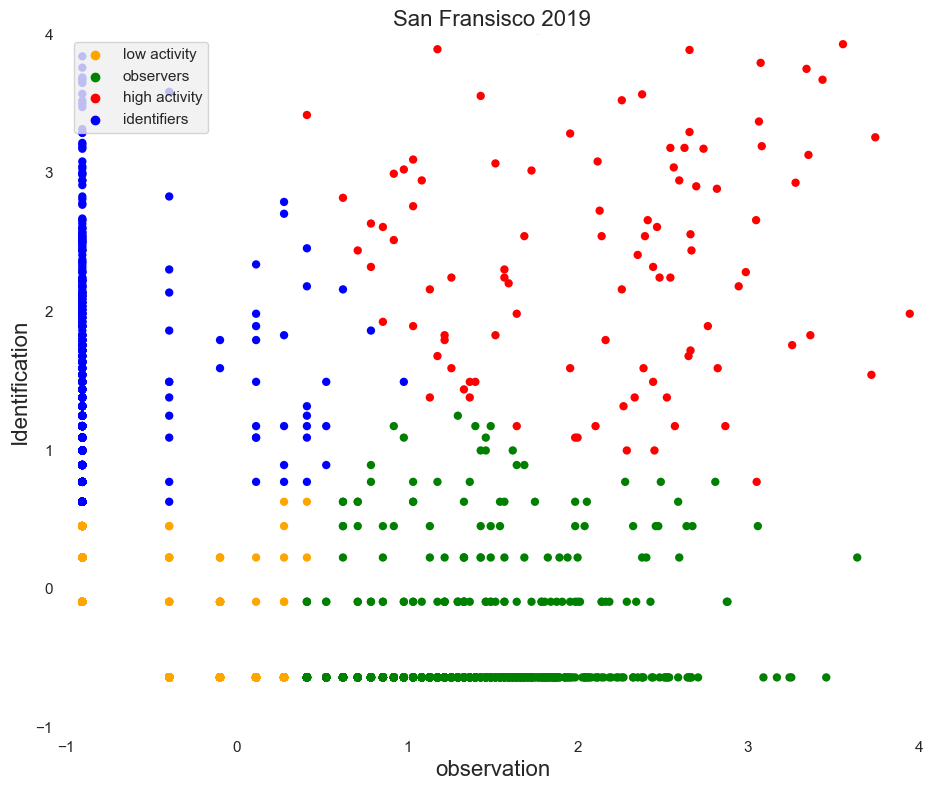

In [43]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))
ax = sns.scatterplot(data=df_std_2019, x = 'obs_count_2019', y ='ident_count_2019',
                     hue='user type 2019',
                     palette=color_dict,
                     s=36, linewidth=0)
plt.legend(loc='upper left')
plt.title('San Fransisco 2019',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

### merge two dataset 2018 and 2019

In [44]:
df = pd.merge(df_std, df_std_2019, on="user_id", how="right")
df.sort_values('user_id')      

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user type 2018,obs_count_2019,ident_count_2019,cluster_2019,user type 2019
4,1,2.726010,4.758159,2.0,high activity,2.857594,4.170202,3,high activity
2778,17,1.531218,-0.699644,3.0,observers,-0.904971,0.626958,2,identifiers
2307,28,3.141866,4.171136,2.0,high activity,-0.904971,4.041201,2,identifiers
2681,160,NaN,NaN,NaN,NaN,-0.904971,0.626958,2,identifiers
3069,172,-0.827617,0.495687,1.0,low activity,-0.904971,0.451250,1,low activity
...,...,...,...,...,...,...,...,...,...
2658,3596875,NaN,NaN,NaN,NaN,-0.904971,-0.094548,1,low activity
2144,3621768,NaN,NaN,NaN,NaN,-0.395394,-0.640347,1,low activity
2235,3657355,NaN,NaN,NaN,NaN,-0.904971,-0.094548,1,low activity
2147,3704356,NaN,NaN,NaN,NaN,-0.395394,-0.640347,1,low activity


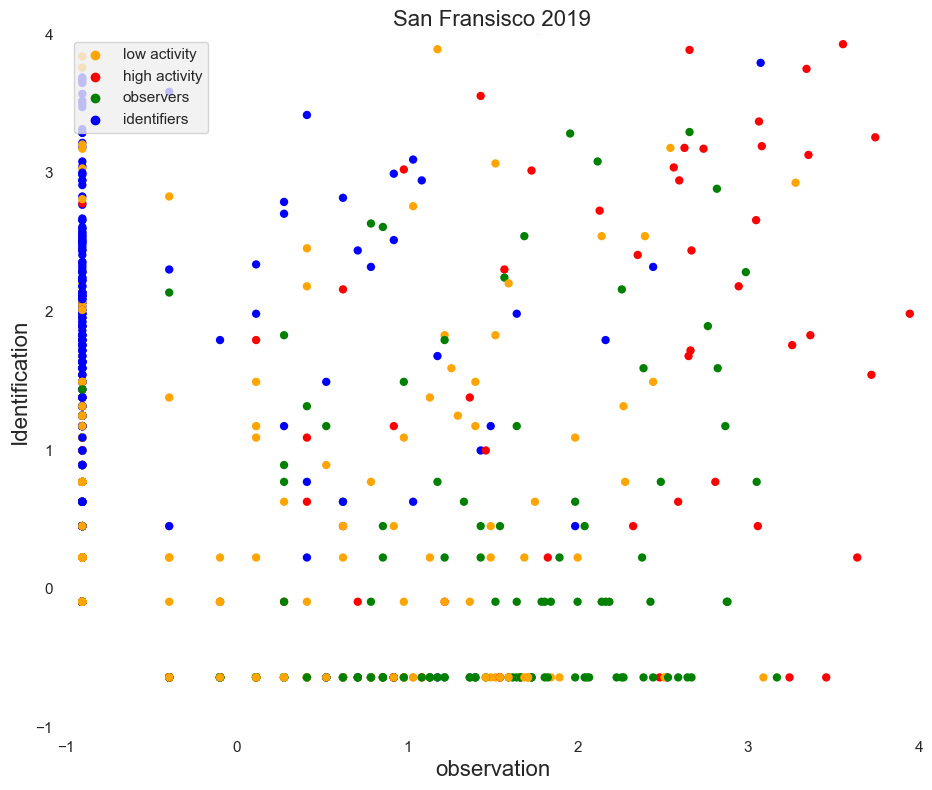

In [45]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)  
ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user type 2018',palette=color_dict, s=36, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

plt.legend(loc='upper left')
plt.title('San Fransisco 2019',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

In [46]:
#test 
higha_2019 = df.loc[df['user type 2019']=='high activity']
higha_2019.sort_values('user_id')

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user type 2018,obs_count_2019,ident_count_2019,cluster_2019,user type 2019
4,1,2.726010,4.758159,2.0,high activity,2.857594,4.170202,3,high activity
527,181,2.138383,-0.184843,3.0,observers,1.642914,1.172757,3,high activity
1337,425,NaN,NaN,NaN,NaN,1.035169,1.894263,3,high activity
1577,462,NaN,NaN,NaN,NaN,2.411251,2.658675,3,high activity
420,477,2.609402,3.834392,2.0,high activity,2.626773,3.180243,3,high activity
...,...,...,...,...,...,...,...,...,...
264,1591079,NaN,NaN,NaN,NaN,2.543940,2.244418,3,high activity
1345,1625655,NaN,NaN,NaN,NaN,1.956156,1.590584,3,high activity
1076,1636069,NaN,NaN,NaN,NaN,1.133337,2.159208,3,high activity
707,1641168,NaN,NaN,NaN,NaN,1.259675,2.244418,3,high activity


## San Francisco 2020

In [47]:
dfcity = dfs['San_Francisco'][2020]
sf_2020 = get_obs_idents_per_user(dfcity)
sf_2020.sort_values('user_id')

,user_id,n_obs,n_idents
5,1,137,830
404,28,303,691
3263,36,0,7
3229,48,0,1
3574,160,0,1
...,...,...,...
3572,3638742,0,1
3237,3657355,0,3
2700,3728745,1,0
2705,3780892,0,1


In [48]:
sf_2020.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,3803.0,1.549301e+06,1.060285e+06,1.0,522822.0,1507622.0,2673847.5,3793896.0
n_obs,3803.0,8.375230e+00,3.215316e+01,0.0,0.0,1.0,4.0,517.0
n_idents,3803.0,8.102025e+00,7.182852e+01,0.0,0.0,0.0,1.0,3494.0


In [49]:
sf_2020['obs_count_1']=sf_2020['n_obs']+1
sf_2020['ident_count_1']=sf_2020['n_idents']+1

In [50]:
#log transform
sf_2020['obs_count_log'] = np.log(sf_2020['obs_count_1'])
sf_2020['ident_count_log'] = np.log(sf_2020['ident_count_1'])

In [51]:
sf_2020.sort_values('user_id').head()

,user_id,n_obs,n_idents,obs_count_1,ident_count_1,obs_count_log,ident_count_log
5,1,137,830,138,831,4.927254,6.72263
404,28,303,691,304,692,5.717028,6.539586
3263,36,0,7,1,8,0.0,2.079442
3229,48,0,1,1,2,0.0,0.693147
3574,160,0,1,1,2,0.0,0.693147


In [52]:
#frames1 = [sf_2019, sf_2020]
#sf_2020 = pd.concat(frames1)
#sf_2020.sort_values('user_id')

In [53]:
#select varibles for plotting
df_select_2020 = sf_2020[['user_id','obs_count_log', 'ident_count_log']]
#create a copy of your dataframe:
df_std_2020 = df_select_2020.copy()
df_std_2020.sort_values('user_id')

,user_id,obs_count_log,ident_count_log
5,1,4.927254,6.72263
404,28,5.717028,6.539586
3263,36,0.0,2.079442
3229,48,0.0,0.693147
3574,160,0.0,0.693147
...,...,...,...
3572,3638742,0.0,0.693147
3237,3657355,0.0,1.386294
2700,3728745,0.693147,0.0
2705,3780892,0.0,0.693147


In [54]:
col_names = ['obs_count_log', 'ident_count_log']
features = df_std_2020[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [55]:
#assign the result to those two columns
df_std_2020[col_names] = features
df_std_2020.rename(columns={'obs_count_log': 'obs_count_2020', 'ident_count_log': 'ident_count_2020'}, inplace=True)
df_std_2020.sort_values('user_id')

,user_id,obs_count_2020,ident_count_2020
5,1,3.307504,5.280194
404,28,3.988825,5.120728
3263,36,-0.943136,1.235093
3229,48,-0.943136,0.027366
3574,160,-0.943136,0.027366
...,...,...,...
3572,3638742,-0.943136,0.027366
3237,3657355,-0.943136,0.631229
2700,3728745,-0.345172,-0.576497
2705,3780892,-0.943136,0.027366


In [57]:
label_dict = {0:'low activity', 1:'identifiers', 2:'observers',3:'high activity'}

kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000).fit(df_std_2020[['obs_count_2020',
                                                                        'ident_count_2020']])
df_std_2020['cluster_2020'] = kmeans.labels_
df_std_2020['user type 2020'] = [label_dict.get(i) for i in df_std_2020.cluster_2020]
df_std_2020.sort_values('user_id')

,user_id,obs_count_2020,ident_count_2020,cluster_2020,user_type2020,user type 2020
5,1,3.307504,5.280194,3,high activity,high activity
404,28,3.988825,5.120728,3,high activity,high activity
3263,36,-0.943136,1.235093,1,identifiers,identifiers
3229,48,-0.943136,0.027366,0,low activity,low activity
3574,160,-0.943136,0.027366,0,low activity,low activity
...,...,...,...,...,...,...
3572,3638742,-0.943136,0.027366,0,low activity,low activity
3237,3657355,-0.943136,0.631229,1,identifiers,identifiers
2700,3728745,-0.345172,-0.576497,0,low activity,low activity
2705,3780892,-0.943136,0.027366,0,low activity,low activity


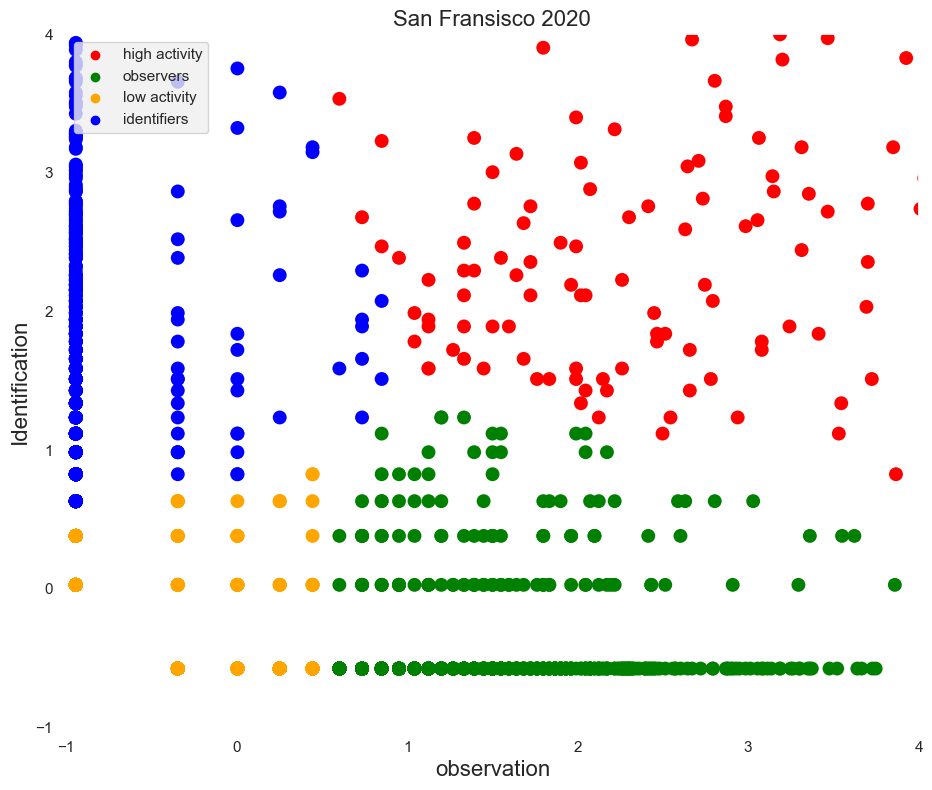

In [58]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))
ax = sns.scatterplot(data=df_std_2020, x = 'obs_count_2020', y ='ident_count_2020',
                     hue='user type 2020',
                     palette=color_dict,
                     s=100, linewidth=0)
plt.legend(loc='upper left')
plt.title('San Fransisco 2020',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

### Merge 2018,2019 and 2020

In [59]:
df1 = pd.merge(df,df_std_2020, on="user_id", how="right")
df1.sort_values('user_id') 

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user type 2018,obs_count_2019,ident_count_2019,cluster_2019,user type 2019,obs_count_2020,ident_count_2020,cluster_2020,user_type2020,user type 2020
5,1,2.726010,4.758159,2.0,high activity,2.857594,4.170202,3.0,high activity,3.307504,5.280194,3,high activity,high activity
404,28,3.141866,4.171136,2.0,high activity,-0.904971,4.041201,2.0,identifiers,3.988825,5.120728,3,high activity,high activity
3263,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.943136,1.235093,1,identifiers,identifiers
3229,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.943136,0.027366,0,low activity,low activity
3574,160,NaN,NaN,NaN,NaN,-0.904971,0.626958,2.0,identifiers,-0.943136,0.027366,0,low activity,low activity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572,3638742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.943136,0.027366,0,low activity,low activity
3237,3657355,NaN,NaN,NaN,NaN,-0.904971,-0.094548,1.0,low activity,-0.943136,0.631229,1,identifiers,identifiers
2700,3728745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.345172,-0.576497,0,low activity,low activity
2705,3780892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.943136,0.027366,0,low activity,low activity


In [60]:
#check user 160 to see different clusters
user = df1.loc[df1['user_id']==160]
user

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user type 2018,obs_count_2019,ident_count_2019,cluster_2019,user type 2019,obs_count_2020,ident_count_2020,cluster_2020,user_type2020,user type 2020
3574,160,NaN,NaN,NaN,NaN,-0.904971,0.626958,2.0,identifiers,-0.943136,0.027366,0,low activity,low activity


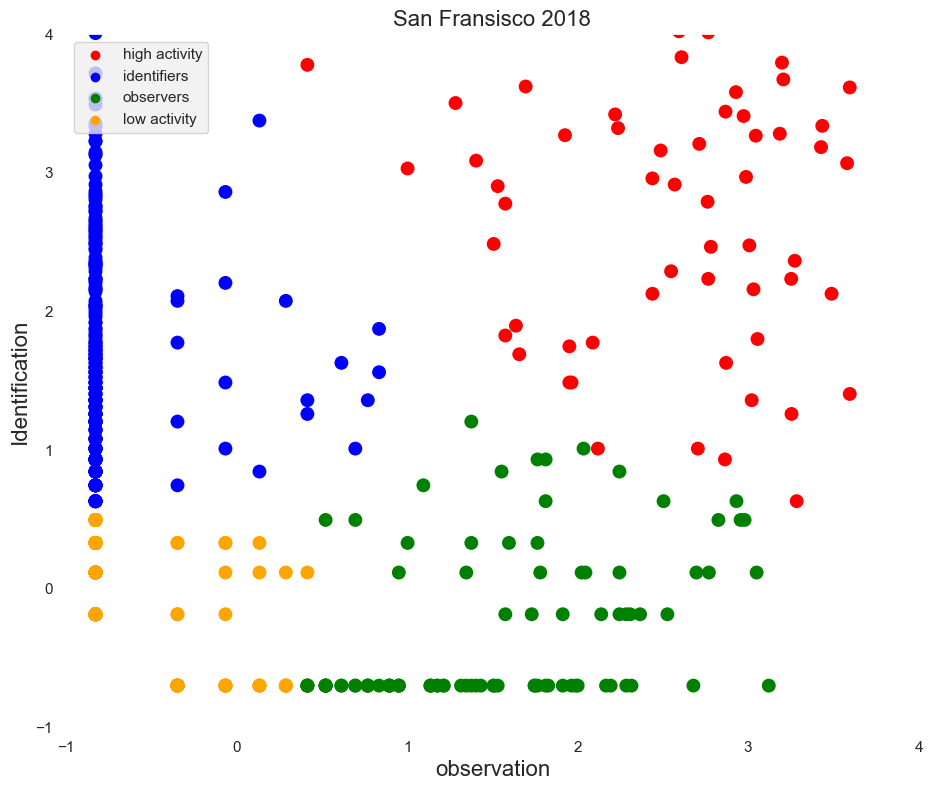

In [63]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))

ax = sns.scatterplot(data=df1, x = 'obs_count_2018', y ='ident_count_2018',  hue='user type 2018',  palette=color_dict, s=100, linewidth=0)  
#ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)


plt.legend(loc='upper left')
plt.title('San Fransisco 2018',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

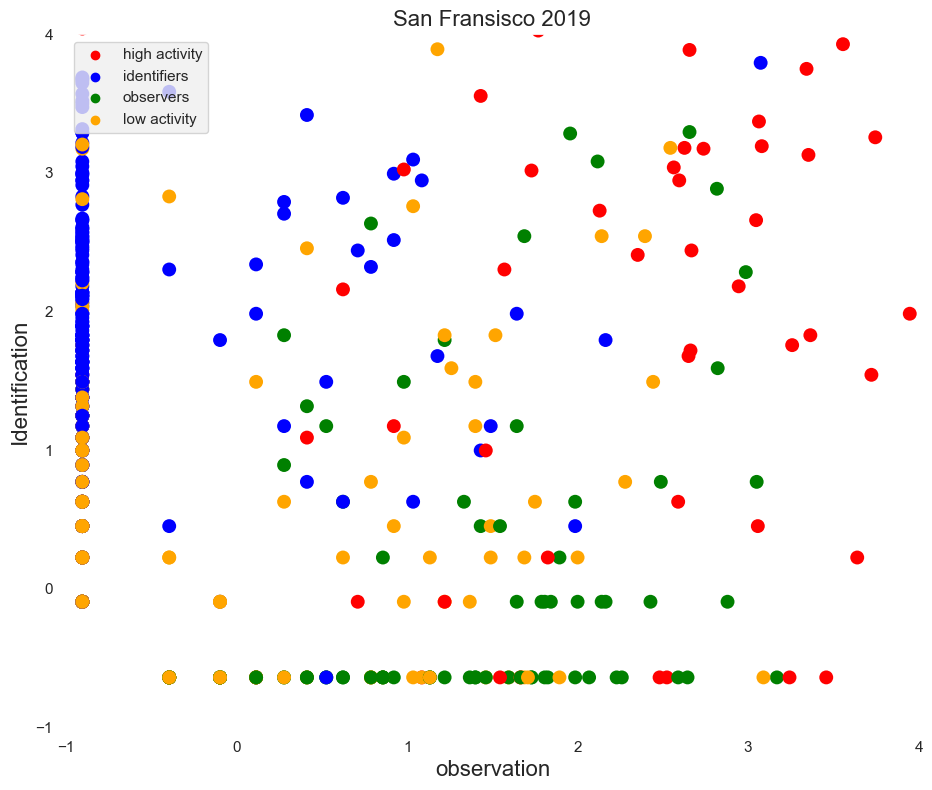

In [64]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))


#ax = ax.add_subplot(gs[1:5,0:3])
ax = sns.scatterplot(data=df1, x = 'obs_count_2019', y ='ident_count_2019',  hue='user type 2018',  palette=color_dict, s=100, linewidth=0)  
#ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)


plt.legend(loc='upper left')
plt.title('San Fransisco 2019',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

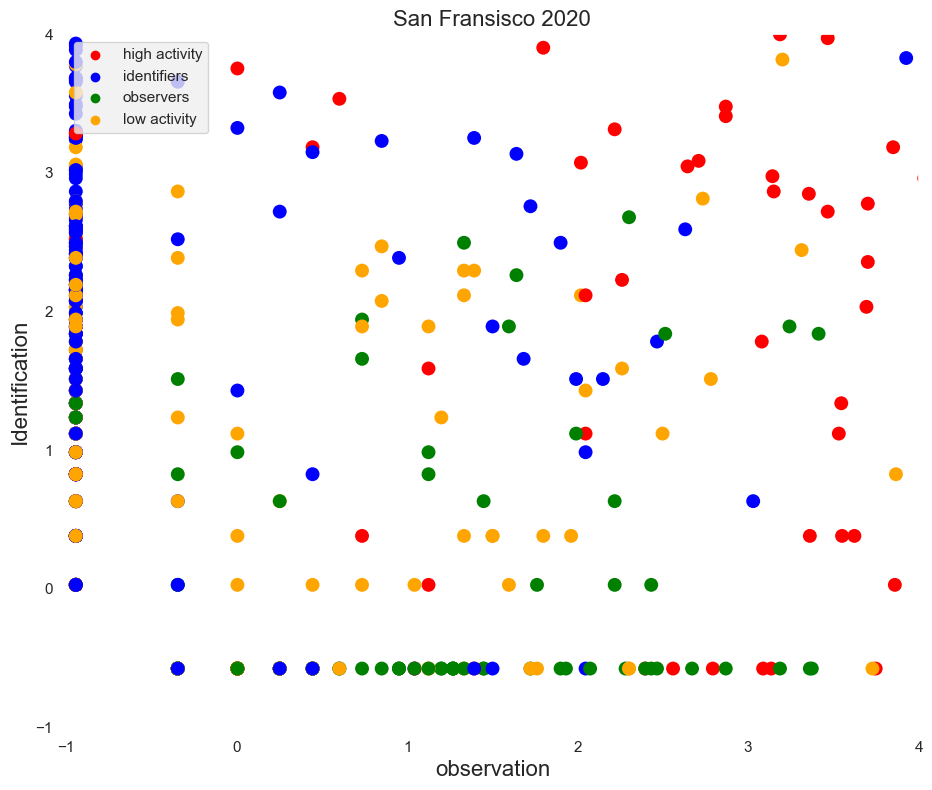

In [65]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))

ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',  hue='user type 2018',  palette=color_dict, s=100, linewidth=0)  
#ax = sns.scatterplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020',hue='user_type2018',palette=color_dict, s=36, linewidth=0)

#ax = sns.scatterplot(data=df, x = 'obs_count_2018', y ='ident_count_2018',  hue='user_type2018',  palette=color_dict, s=36, linewidth=0)
#ax = sns.scatterplot(data=df, x = 'obs_count_2019', y ='ident_count_2019',hue='user_type2018',palette=color_dict, s=36, linewidth=0)


plt.legend(loc='upper left')
plt.title('San Fransisco 2020',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
ax.set_xlim(-1,4)
ax.set_ylim(-1,4)
ax.set_facecolor("white")
plt.savefig('scatter.png')
plt.show()

In [66]:
df1.fillna(0)

,user_id,obs_count_2018,ident_count_2018,cluster_2018,user type 2018,obs_count_2019,ident_count_2019,cluster_2019,user type 2019,obs_count_2020,ident_count_2020,cluster_2020,user_type2020,user type 2020
0,2692,3.206729,3.674031,2.0,high activity,3.139357,4.672844,3.0,high activity,3.914794,4.060858,3,high activity,high activity
1,179103,3.542172,5.300866,2.0,high activity,3.653421,5.646786,3.0,high activity,4.158320,6.531623,3,high activity,high activity
2,819,3.435052,3.339223,2.0,high activity,3.512493,4.288578,3.0,high activity,4.033075,2.960922,3,high activity,high activity
3,2825732,0.000000,0.000000,0.0,0,0.000000,0.000000,0.0,0,2.123989,0.631229,2,observers,observers
4,2556410,0.000000,0.000000,0.0,0,0.000000,0.000000,0.0,0,0.445293,-0.576497,0,low activity,low activity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3798,2563903,0.000000,0.000000,0.0,0,-0.904971,-0.094548,1.0,low activity,-0.943136,0.027366,0,low activity,low activity
3799,1131523,0.000000,0.000000,0.0,0,0.000000,0.000000,0.0,0,-0.943136,0.027366,0,low activity,low activity
3800,523509,0.000000,0.000000,0.0,0,0.000000,0.000000,0.0,0,-0.943136,0.027366,0,low activity,low activity
3801,3098822,0.000000,0.000000,0.0,0,0.000000,0.000000,0.0,0,-0.943136,0.027366,0,low activity,low activity


## 2D Contour Plot (Density Plot)

### San Fransisco 2018 

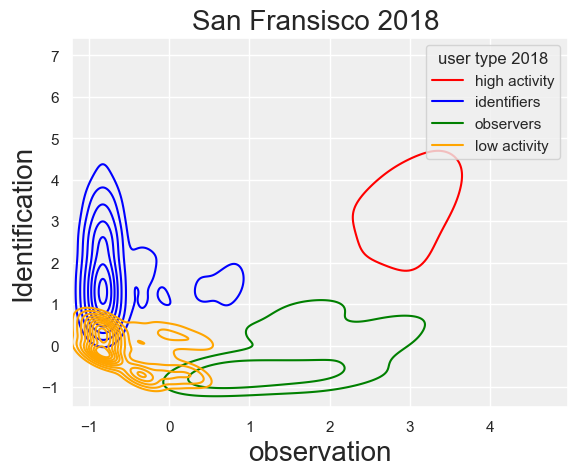

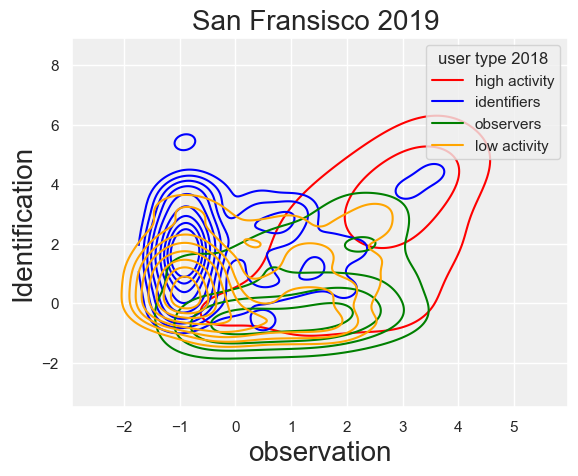

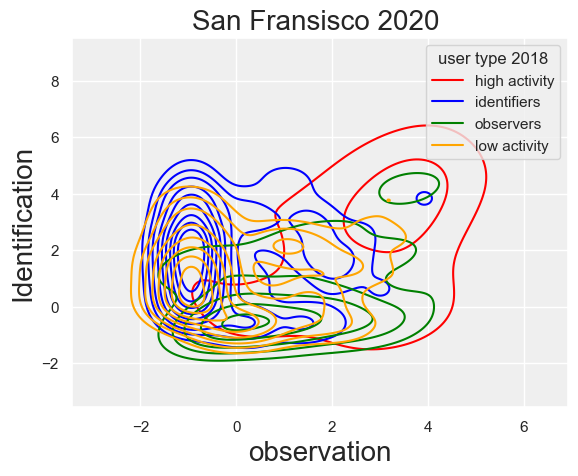

In [68]:
#data=df_std_2020, x = 'obs_count_2020', y ='ident_count_2020', hue='user_type2020'
    
# Basic 2D density plot
#sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018,legend=True)
#sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019,hue='user_type2019')
sns.kdeplot(data=df1, x = 'obs_count_2018', y ='ident_count_2018', hue='user type 2018',palette=color_dict)
plt.title('San Fransisco 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

sns.kdeplot(data=df1, x = 'obs_count_2019', y ='ident_count_2019', hue='user type 2018',palette=color_dict)
plt.title('San Fransisco 2019 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

sns.kdeplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020', hue='user type 2018',palette=color_dict)
plt.title('San Fransisco 2020 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()


#sns.kdeplot(data=df_std, x = 'obs_count_2018', y ='ident_count_2018', hue='user_type2018')
#sns.kdeplot(data=df_std_2019, x = 'obs_count_2019', y ='ident_count_2019', hue='user_type2019')
#sns.kdeplot(data=df_std_2020, x = 'obs_count_2020', y ='ident_count_2020', hue='user_type2020')


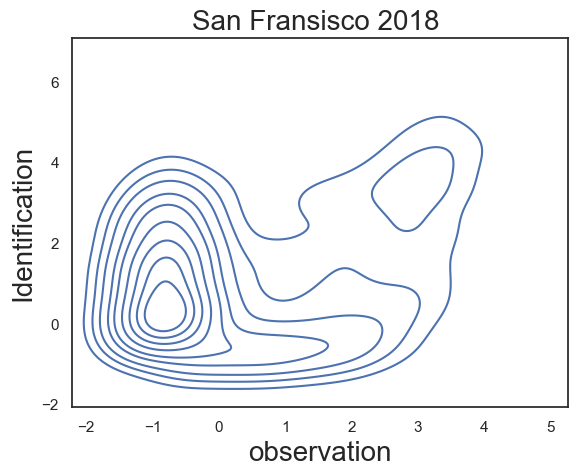

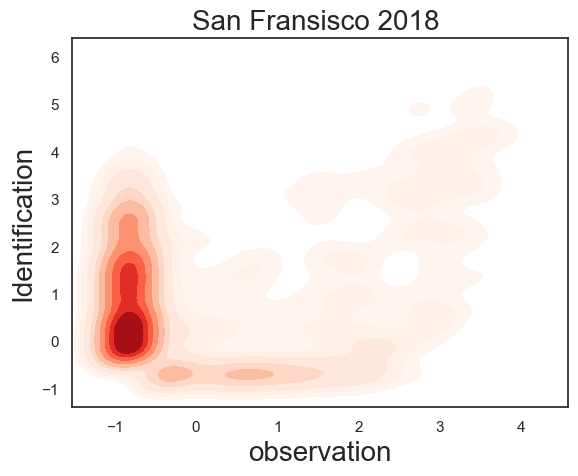

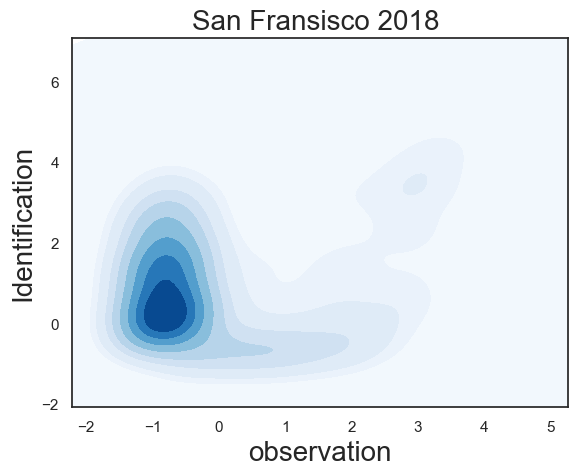

In [251]:
# set seaborn style
sns.set_style("white")

# Basic 2D density plot
sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018,legend=True)
#sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019,legend=True)
#sns.kdeplot(x=df1.obs_count_2020, y=df1.ident_count_2020)
plt.title('San Fransisco 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

# Custom the color, add shade and bandwidth
sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018,cmap="Reds", shade=True, bw_adjust=.5)
plt.title('San Fransisco 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

# Add thresh parameter
sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018, cmap="Blues", shade=True, thresh=0)
plt.title('San Fransisco 2018 ',fontsize=20)
plt.xlabel('observation',fontsize=20) #x label
plt.ylabel('Identification',fontsize=20) #y label
plt.show()

### London 2018, 2019 and 2020 in one figure 

In [252]:
import matplotlib.patches as  mpatches


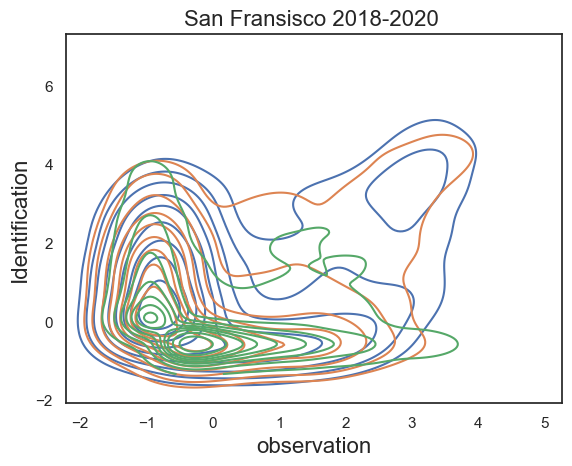

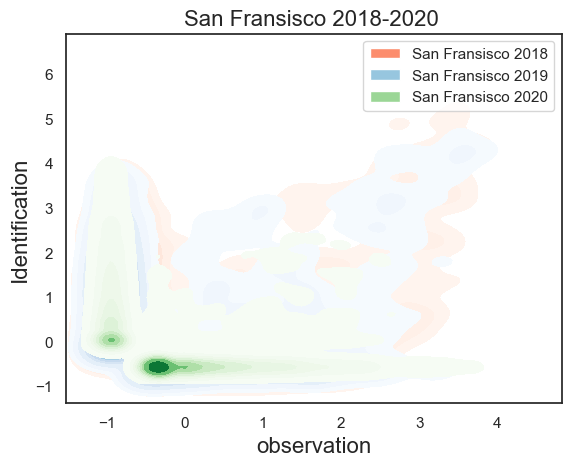

In [253]:
sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018 )
sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019)
sns.kdeplot(x=df1.obs_count_2020, y=df1.ident_count_2020)
plt.title('San Fransisco 2018-2020 ',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
plt.show()

sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018, cmap="Reds", shade=True, bw_adjust=.5,label='San Fransisco 2018')
sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019, cmap="Blues", shade=True, bw_adjust=.5,label='San Fransisco 2019')
sns.kdeplot(x=df1.obs_count_2020, y=df1.ident_count_2020, cmap="Greens", shade=True, bw_adjust=.5,label='San Fransisco 2020')
handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="San Fransisco 2018"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="San Fransisco 2019"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="San Fransisco 2020")]
plt.legend(handles=handles)
plt.title('San Fransisco 2018-2020 ',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
plt.show()


## Different types of User Activity 2018, 2019 and 2020 

In [254]:
#high activity users 2018, 2019, 2020 
higha_2018 = df_std.loc[df_std['user_type2018']=='high activity']
higha_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='high activity']
higha_2020 = df_std_2020.loc[df_std_2020['user_type2020']=='high activity']

In [255]:
#low activity users 2018, 2019, 2020 
lowa_2018 = df_std.loc[df_std['user_type2018']=='low activity']
lowa_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='low activity']
lowa_2020 = df_std_2020.loc[df_std_2020['user_type2020']=='low activity']

In [256]:
#observers 2018, 2019, 2020 
obs_2018 = df_std.loc[df_std['user_type2018']=='observers']
obs_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='observers']
obs_2020 = df_std_2020.loc[df_std_2020['user_type2020']=='observers']

In [257]:
#identifiers 2018, 2019, 2020 
iden_2018 = df_std.loc[df_std['user_type2018']=='identifiers']
iden_2019 = df_std_2019.loc[df_std_2019['user_type2019']=='identifiers']
iden_2020 = df_std_2020.loc[df_std_2020['user_type2020']=='identifiers']

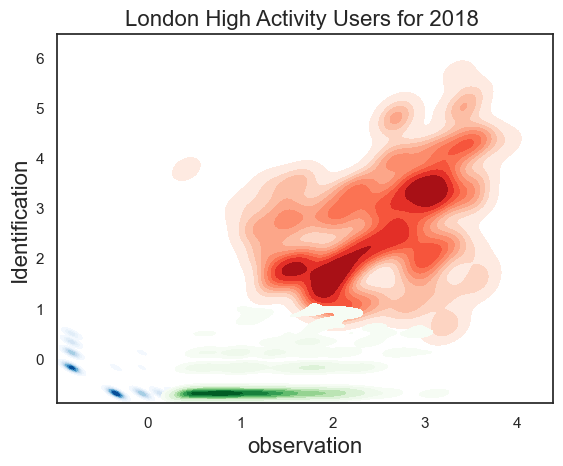

In [258]:
sns.kdeplot(x=higha_2018.obs_count_2018, y=higha_2018.ident_count_2018, cmap="Reds", shade=True, bw_adjust=.5)
sns.kdeplot(x=lowa_2018.obs_count_2018, y=lowa_2018.ident_count_2018, cmap="Blues", shade=True, bw_adjust=.5)
sns.kdeplot(x=obs_2018.obs_count_2018, y=obs_2018.ident_count_2018, cmap="Greens", shade=True, bw_adjust=.5)
#sns.kdeplot(x=iden_2018.obs_count_2018, y=iden_2018.ident_count_2018, cmap="Blues", shade=True, bw_adjust=.5)
plt.title('London High Activity Users for 2018 ',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
plt.show()

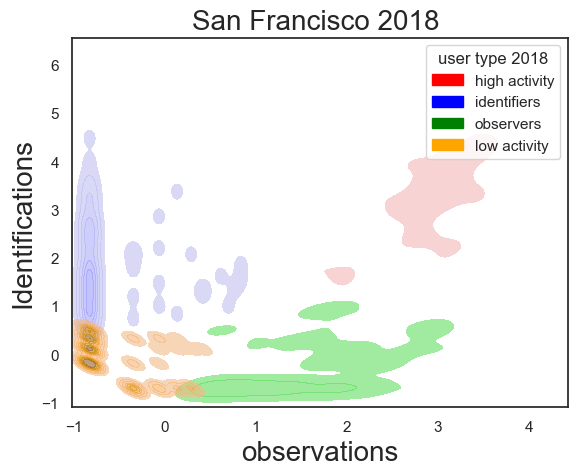

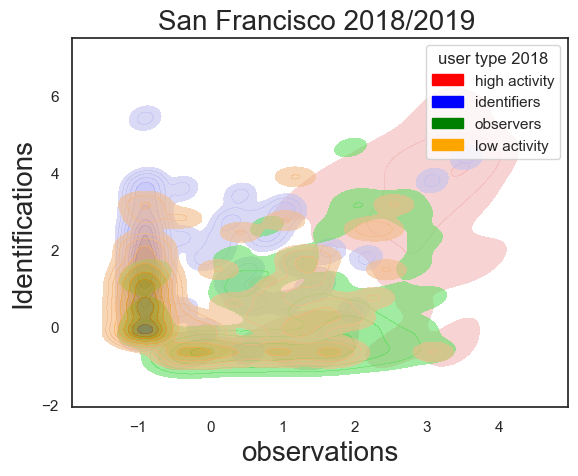

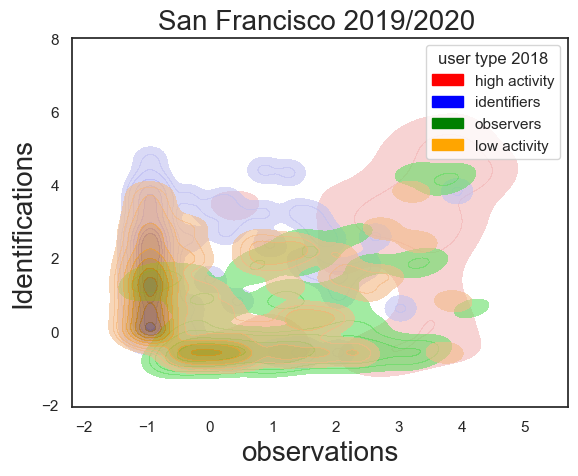

In [70]:
#data=df_std_2020, x = 'obs_count_2020', y ='ident_count_2020', hue='user_type2020'
# set seaborn style
sns.set_style("white")

# Basic 2D density plot
#sns.kdeplot(x=df1.obs_count_2018, y=df1.ident_count_2018,legend=True)
#sns.kdeplot(x=df1.obs_count_2019, y=df1.ident_count_2019,hue='user_type2019')
sns.kdeplot(data=df1, x = 'obs_count_2018', y ='ident_count_2018', hue='user type 2018',palette=color_dict,shade=True, bw_adjust=.5,alpha=0.6)
plt.title('San Francisco 2018 ',fontsize=20)
plt.xlabel('observations',fontsize=20) #x label
plt.ylabel('Identifications',fontsize=20) #y label
plt.show()

sns.kdeplot(data=df1, x = 'obs_count_2019', y ='ident_count_2019', hue='user type 2018',palette=color_dict,shade=True, bw_adjust=.5,alpha=0.6)
plt.title('San Francisco 2018/2019 ',fontsize=20)
plt.xlabel('observations',fontsize=20) #x label
plt.ylabel('Identifications',fontsize=20) #y label
plt.show()

sns.kdeplot(data=df1, x = 'obs_count_2020', y ='ident_count_2020', hue='user type 2018',palette=color_dict,shade=True, bw_adjust=.5,alpha=0.6)
plt.title('San Francisco 2019/2020 ',fontsize=20)
plt.xlabel('observations',fontsize=20) #x label
plt.ylabel('Identifications',fontsize=20) #y label
plt.show()


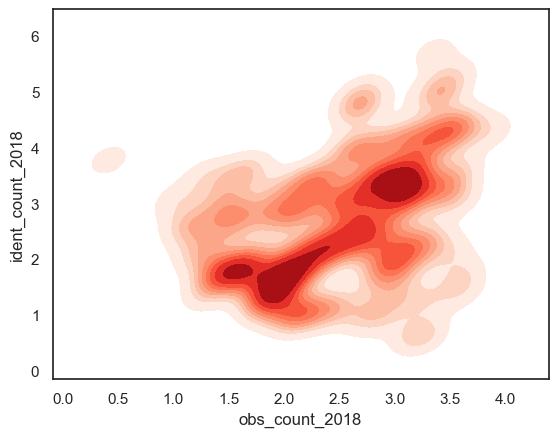

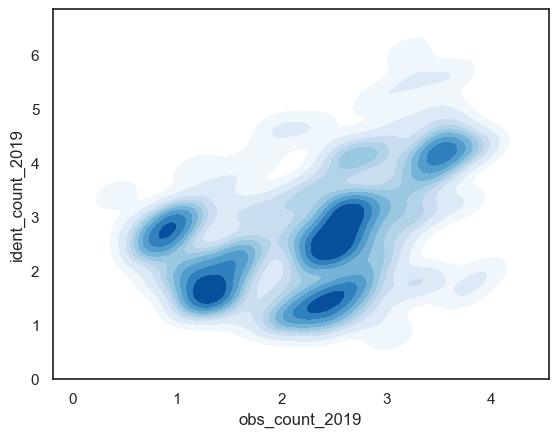

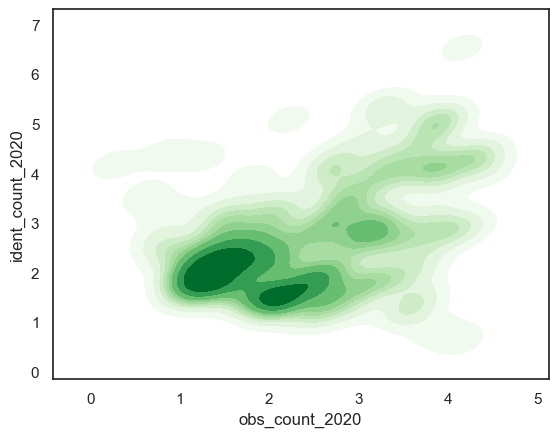

Text(0, 0.5, 'Identification')

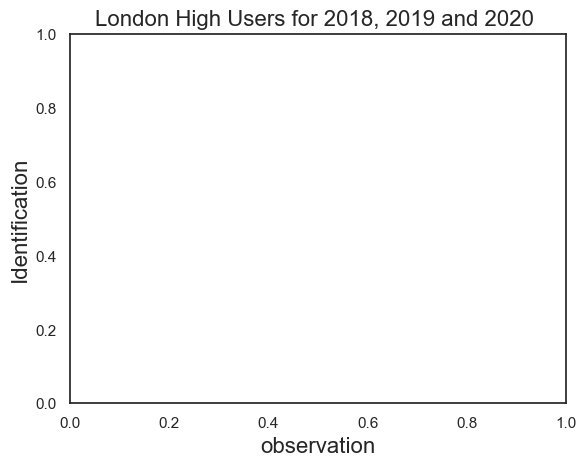

In [259]:
sns.kdeplot(x=higha_2018.obs_count_2018, y=higha_2018.ident_count_2018, cmap="Reds", shade=True, bw_adjust=.5)
plt.show()
sns.kdeplot(x=higha_2019.obs_count_2019, y=higha_2019.ident_count_2019, cmap="Blues", shade=True, bw_adjust=.5)
plt.show()
sns.kdeplot(x=higha_2020.obs_count_2020, y=higha_2020.ident_count_2020, cmap="Greens", shade=True, bw_adjust=.5)
plt.show()
plt.title('London High Users for 2018, 2019 and 2020 ',fontsize=16)
plt.xlabel('observation',fontsize=16) #x label
plt.ylabel('Identification',fontsize=16) #y label
#plt.show()

###Test

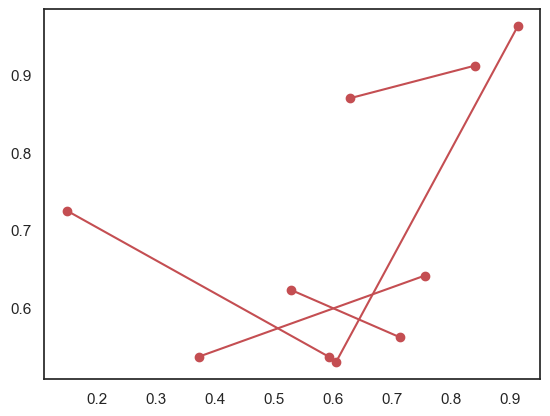

In [260]:
###Test
import numpy as np
import matplotlib.pyplot as plt

x, y = np.random.random(size=(2,10))

for i in range(0, len(x), 2):
    plt.plot(x[i:i+2], y[i:i+2], 'ro-')

plt.show()

In [261]:
import plotly.express as px


In [132]:
ax = plt.figure(figsize=(11,9))
ax = px.line(df1, x="obs_count_2018", y="ident_count_2018", color="cluster_2018", text="user_type2018")
ax = px.line(df1, x="obs_count_2019", y="ident_count_2019", color="cluster_2019", text="user_type2018")
fig.update_traces(textposition="bottom right")
fig.show()




<Figure size 1100x900 with 0 Axes>

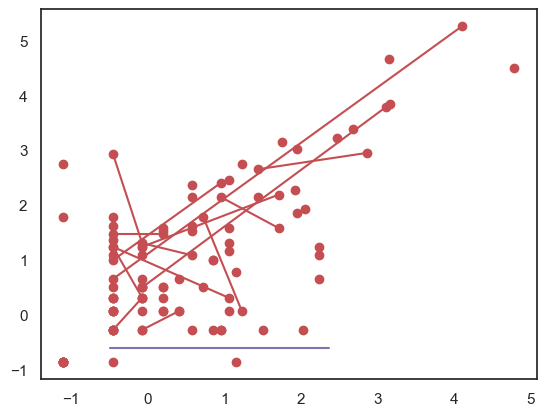

In [117]:
import matplotlib.pyplot as plt
x= df1['obs_count_2018']
y= df1['ident_count_2018']

x1= df1['obs_count_2019']
y1= df1['ident_count_2019']

plt.figure()
for i in range(0, len(x), 2):
    #plt.plot(x[i:i+2], y[i:i+2], 'ro-')
    plt.plot(x[i:i+2], x1[i:i+2],y[i:i+2], y1[i:i+2], 'ro-')
    # Show/save figure as desired.
plt.show()
#plt.show()



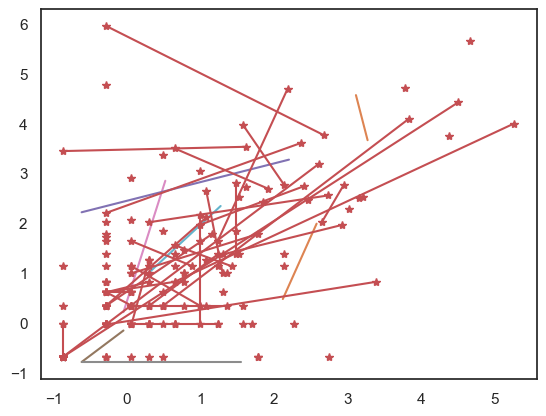

In [118]:
import matplotlib.pyplot as plt
x= df1['obs_count_2019']
y= df1['ident_count_2019']

x1= df1['obs_count_2020']
y1= df1['ident_count_2020']

plt.figure()
for i in range(0, len(x), 2):
    plt.plot(x[i:i+2], x1[i:i+2],y[i:i+2], y1[i:i+2], 'r*-')
    # Show/save figure as desired.
plt.show()
# Can show all four figures at once by calling plt.show() here, outside the loop.
#plt.show()


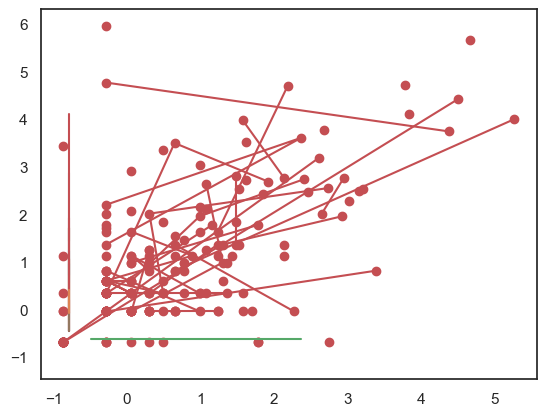

In [113]:
x= df1['obs_count_2018']
y= df1['ident_count_2018']

x1= df1['obs_count_2019']
y1= df1['ident_count_2019']

x2= df1['obs_count_2020']
y2= df1['ident_count_2020']

plt.figure()
for i in range(0, len(x), 3):
    #plt.plot(x[i:i+2], y[i:i+2], 'ro-')
    plt.plot(x[i:i+3], x1[i:i+3],x2[i:i+3],y[i:i+3], y1[i:i+3],y2[i:i+3], 'ro-')
    # Show/save figure as desired.
plt.show()
#plt.show()
